**Uncertainty calculation of plastic emission fate factors (FF)**

In this notebook the uncertainty and distribution of plastic emission fate factors is conducted. Therefore, the following approach is followed:
1. Import and handling/parsing of the excel sheet named *Supplementary Material 2.xlsx*
2. Calculation of the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) and cleaning of the dataframe
3. Setting a dataframe called (df_SSDR_new) which includes all the necessary stuff for calculation
4. Calculation of the average SSDR for all polymer types and compartments where
    * column 'SSDR expert judgment based on' not equals Exp+compatment leading to df_SSDR_basic
    * column 'SSDR expert judgment based on' equals Exp+compartment lead to df_exp
    * merging of the to dataframes to retrieve the SSDR with uncertainty dataframe (df_SSDR)
5. Calculation the GSD for the SSDRs and storing the values in an excel sheet
6. Calculation of the average lifetimes and storing the values in an excel sheet
7. Retrieving redistribution values from excel sheet named *Supplementary Material 2.xlsx*
8. Calculation of plastic emissions fate factor
9. Visualization

In [1]:
# importing the usual stuff
import random
import scipy
from scipy import stats, optimize, interpolate
from scipy.stats import skew, gmean, gstd
from statistics import geometric_mean
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import math
import time
import re
import seaborn as sns
from openpyxl import load_workbook
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

TodaysDate = time.strftime("%Y%m%d")

# Defining the function for calculating the coefficient of variation (CV) using the predefined data quality indicators and calculating CVs for each data point

In [2]:
# defining function for CV calculation
def CV(rel, comp1, comp2, temp, geo, mea, exp):
    # function depended on the DQIS for reliability, completeness 1,
    # completeness2, temporal correlation, geographical correlation,
    # and mearuement method. Expert judgments are handled differently
    a_rel = 0.75  # a parameters b parameter defined as explained in manuscript
    a_comp1 = 1.5
    a_comp2 = 1.5
    a_temp = 0.375
    a_geo = 1.5
    a_mea = 1.5
    a_exp = 2.5
    b = 1.105
    if exp == 0:
        # calculates all CVs for the data points expect for the ones which
        # are based on expert judgment
        CV_rel = a_rel*math.exp(b*rel)
        if comp1 == 1:
            # if comp1 is 1 then CV is 0 this is the case as it is assumed
            # that there is no uncertainty when DQIS is 1 in the comp1
            CV_comp1 = 0
        else:
            CV_comp1 = a_comp1*math.exp(b*(comp1-1))
        if comp2 == 1:
            CV_comp2 = 0
        else:
            CV_comp2 = a_comp2*math.exp(b*(comp2-1))
        if temp == 1:
            CV_temp = 0
        else:
            CV_temp = a_temp*math.exp(b*(temp-1))
        if geo == 1:
            CV_geo = 0
        else:
            CV_geo = a_geo*math.exp(b*(geo-1))
        CV_mea = a_mea*math.exp(b*mea)
        # sum of all
        return math.sqrt(((CV_rel/100)**2+1) * ((CV_comp1/100)**2+1) *
                         ((CV_comp2/100)**2+1) * ((CV_temp/100)**2+1) *
                         ((CV_geo/100)**2+1) * ((CV_mea/100)**2+1)-1)
    # CV squares and the square root to calculate the total CV for
    # the data point under investigation
    else:
        # calulation of CV if an expert judgment
        # was applied for data generation
        return a_exp*math.exp(b*exp)/100

In [3]:
# reading excel file with name "Supplementary Material 2.xlsx"
# and calculating CV relying on DQIS
df = pd.read_excel('Supplementary Material 2.xlsx',
                   sheet_name='DQ of SSDR', skiprows=2)
df['CV'] = df.apply(lambda row: CV(float(row['DQIS_rel']),
                                   float(row['DQIS_comp1']),
                                   float(row['DQIS_comp2']),
                                   float(row['DQIS_temp']),
                                   float(row['DQIS_geo']),
                                   float(row['DQIS_mea']),
                                   float(row['DQIS_exp'])), axis=1)

In [4]:
# Creating an excel file with the original data and the calculated CVs
excel_name = TodaysDate + '_fate_factor_calculation.xlsx'
writer = pd.ExcelWriter(excel_name, engine='openpyxl')
df.to_excel(writer, sheet_name='Original_with_CV', index=False)
writer.save()

In [5]:
# get a list of all polymers used in the excel file
poly = df['Polymer type'].unique().tolist()
# get a list of all compartments in the excel file and remove
# fresh water as it is not considered in further calculations
comp = df['Compartment'].unique().tolist()
# comp.remove('fresh water')
# create a new dataframe with only the colums of
# polymer type, compartment, SSDR, CV and Uncertainty
df_SSDR_new = pd.DataFrame(columns=['Polymer type', 'Compartment', 'SSDR',
                                    'CV', 'SSDR expert judgment based on'])
# generating a reduced df (df_poly_reduced) for each polymer
# and each compartment containing polymer type, compartment,
# SSDR, CV, Uncertainty
for polymer in poly:
    df_poly_reduced = df.loc[(df['Polymer type'] == polymer), ['Polymer type',
                                                               'Compartment',
                                                               'SSDR',
                                                               'CV',
                                                               'SSDR expert judgment based on']]
    for compartment in comp:
        df_poly_comp_reduced = df_poly_reduced.loc[(
            df_poly_reduced['Compartment'] == compartment), :]
        # finding the lowest CV
        min_CV = df_poly_comp_reduced['CV'].min()
        # finding the number how often the minimal CV occurs
        num_min_CV = df_poly_comp_reduced.CV.value_counts()[min_CV]
        # Difference between cases were the number of minimal
        # CVs occurs is equal to one or not
        if num_min_CV == 1:
            # retrieving SSDR for min_CV value from dataframe (df_poly_reduced)
            # and adding this to the dataframe (df_SSDR_new)
            df_poly_comp_reduced = df_poly_comp_reduced.loc[(
                df_poly_comp_reduced['CV'] == min_CV), :]
            df_SSDR_new.loc[len(df_SSDR_new.index)] = [polymer, compartment,
                                                       df_poly_comp_reduced.values[0][2],
                                                       df_poly_comp_reduced.values[0][3],
                                                       df_poly_comp_reduced.values[0][4]]
        else:
            # same as in the if statetment but using mean of SSDR
            # because SSDR is occuring several times with the same min_CV value
            df_poly_comp_reduced = df_poly_comp_reduced.loc[(
                df_poly_comp_reduced['CV'] == min_CV), :]
            SSDR = scipy.stats.gmean(df_poly_comp_reduced['SSDR'])
            df_SSDR_new.loc[len(df_SSDR_new.index)] = [
                polymer, compartment, SSDR, min_CV, 'NaN']
df_SSDR_new

,Polymer type,Compartment,SSDR,CV,SSDR expert judgment based on
0,HDPE,marine sediment,11.703125,0.227893,EXP+marine water
1,HDPE,marine water,11.699359,0.630773,NaN
2,HDPE,river sediment,11.703125,0.227893,EXP+marine water
3,HDPE,soil,11.703125,0.227893,EXP+marine water
4,LDPE,marine sediment,0.706833,0.472005,NaN
...,...,...,...,...,...
91,PVC,soil,0.001000,2.077407,NaN
92,Starch-blend,marine sediment,42.740047,0.227893,EXP+soil
93,Starch-blend,marine water,101.290255,0.146425,NaN
94,Starch-blend,river sediment,42.740047,0.227893,EXP+soil


In [6]:
# setting a list which includes only expert estimates
# and the compartment which they rely on and build dataframes
exp = ['EXP+marine water', 'EXP+marine sediment',
       'EXP+soil', 'EXP+river sediment']
df_SSDR_basic = df_SSDR_new.loc[~df_SSDR_new['SSDR expert judgment based on']
                                .isin(exp)]
df_SSDR_exp = df_SSDR_new.loc[df_SSDR_new['SSDR expert judgment based on']
                              .isin(exp)]

# creating of several dictionaries which will be
# filled for the expert judgment uncertainty
CV_dict_exp = dict()
CV_dict_basic = dict()
SSDR_dict_exp = dict()

# filling the CV_dict_basic dictionary with the names
# and SSDR for already set polymer types and compartments
for i in range(0, len(df_SSDR_basic)):
    name_basic = df_SSDR_basic.iloc[i]['Polymer type'] + \
        ', ' + df_SSDR_basic.iloc[i]['Compartment']
    CV_dict_basic[name_basic] = (
        df_SSDR_basic.iloc[i]['SSDR'], df_SSDR_basic.iloc[i]['CV']**2)

# filling the CV_dict_exp dictionaries with the name and SSDR of the
# expert judgments and calculating the new CV for the expert judgments
# consiting of the already calculated CV for the expert judgment and the
# basic uncertainty of the addtional uncertainy coming from the inital
# value the SSDR is taken from
for i in range(0, len(df_SSDR_exp)):
    name_exp = df_SSDR_exp.iloc[i]['Polymer type'] + ', ' + df_SSDR_exp.iloc[i]['Compartment'] + \
        ', ' + \
        re.findall('\+(.+)', df_SSDR_exp.iloc[i]
                   ['SSDR expert judgment based on'])[0]
    SSDR_dict_exp[name_exp] = CV_dict_basic.get(
        name_exp.split(', ')[0] + ', ' + name_exp.split(', ')[2], 0)[0]
    CV_dict_exp[name_exp] = (df_SSDR_exp.iloc[i]['CV'])**2
    CV_dict_exp[name_exp] = math.sqrt((CV_dict_exp.get(name_exp, 0)+1) * (
        CV_dict_basic.get(name_exp.split(', ')[0] + ', ' + name_exp.split(', ')[2], 0)[1]+1)-1)

# merging of the two dictionaries consisting of the SSDRs and CVs
# for the expert estimates (SSDR_dict_exp and CV_dict_exp)
dcts = [SSDR_dict_exp, CV_dict_exp]

# organizing of the new dataframe (df_SSDR_exp)
df_SSDR_exp = pd.DataFrame(dcts).T
df_SSDR_exp.reset_index(level=0, inplace=True)
cols = {'columns': {'index': 'Polymer', 0: 'SSDR', 1: 'CV'}}
df_SSDR_exp = df_SSDR_exp.rename(**cols)
df_SSDR_exp
df_SSDR_exp[['Polymer type', 'Compartment', 'Exp']
            ] = df_SSDR_exp.Polymer.str.split(', ', expand=True)
df_SSDR_exp = df_SSDR_exp[['Polymer type', 'Compartment', 'SSDR', 'CV']]

# merging of the two dataframes consisting either the
# already set SSDRs and CVs and expert values
frames = [df_SSDR_basic, df_SSDR_exp]
df_SSDR = pd.concat(frames)
df_SSDR = df_SSDR[['Polymer type', 'Compartment', 'SSDR', 'CV']]
df_SSDR

,Polymer type,Compartment,SSDR,CV
1,HDPE,marine water,11.699359,0.630773
4,LDPE,marine sediment,0.706833,0.472005
5,LDPE,marine water,5.657500,0.253505
9,NR/SBR,marine water,43.650000,0.629620
13,PA,marine water,292.000000,0.146425
...,...,...,...,...
43,PU,marine sediment,193.000000,0.517929
44,PU,river sediment,193.000000,0.517929
45,PU,soil,193.000000,0.517929
46,Starch-blend,marine sediment,42.740047,0.335799


# Calculationg of standard deviation based on the CV for each data point

In [7]:
# calculation of the geometric standard deviation
# according to Muller et al. (2016)
def GSD(CV):
    return math.exp(math.sqrt(math.log((CV**2)+1)))

In [8]:
# Application of the GSD function to all rows and SSDRs and sorting by polymer type and compartment
df_SSDR['GSD'] = df_SSDR.apply(lambda row: GSD(float(row['CV'])), axis=1)
df_SSDR = df_SSDR.sort_values(by=['Polymer type', 'Compartment'])

In [9]:
# Building of a dictionary containing the name as key (composed of polymer type and compartment) and a tuple as value
# containing the SSDR and GSD
SSDR_dict = {}

for i in range(0, len(df_SSDR)):
    name = df_SSDR.iloc[i]['Polymer type'] + \
        ', ' + df_SSDR.iloc[i]['Compartment']
    SSDR_dict[name] = df_SSDR.iloc[i]['SSDR'], df_SSDR.iloc[i]['GSD']

In [10]:
# Creating an excel file with the SSDR and uncertainty based on df_SSDR
book = load_workbook(excel_name)
writer = pd.ExcelWriter(excel_name, engine='openpyxl')
writer.book = book
df_SSDR.to_excel(writer, sheet_name='SSDR_with_Uncertainty', index=False)
writer.save()

# Fate factor calculation

In [11]:
# defining elements (polymer type, compartment, shape, characterisitc length) for the calculation of the fate factor
polymer_type = df_SSDR['Polymer type'].unique().tolist()
compartment = ['air', 'fresh water', 'marine water', 'soil']
shape_dict = {'film': 2, 'fiber': 4, 'particle': 6}
shape = list(shape_dict.keys())
char_length = ['0.01-0.1 mm', '0.1-1 mm', '1-10 mm']

# building a list of all environmental flows containing the above describe elements
flows = list()
for polymer in polymer_type:
    for form in shape:
        for length in char_length:
            for comp in compartment:
                flows.append('DE: ' + polymer + ' ' + form + ' ' + length +
                            ' ' + '(emission to ' + comp + ')')
# setting up a dictionary for the elementary flows
flows_dict = {}
# building of a dictionary containing the environmental flow as key and a tuple containing the polymer type, shape,
# characterisitc lenght and initial compartment as value
for flow in flows:
    names = re.findall('^DE: (.+)', flow)
    polymer_type = names[0].split(' ')[0]
    shape = names[0].split(' ')[1]
    characteristic_length = float(names[0].split(
        ' ')[2].split('-')[1].replace(',', '.'))
    initial_compartment = re.findall(
        'to (.+)', re.findall('\((.*?)\)', names[0])[-1])[0]
    flows_dict[names[0]] = polymer_type, shape, characteristic_length, initial_compartment

In [12]:
# defining a function calculating the CV for expert judgments only, as this is necessary for the further calculation
def CV_exp(exp):
    a_exp = 2.5
    b = 1.105
    return a_exp*math.exp(b*exp)/100

In [13]:
# setting up a dictionary for the average lifetime calculation
t_i_dict = {}
length = [0.1, 1.0, 10.0]
# looping through the dataframe df_SSDR to get name, SSDR, and GSDi
for i in range(0, len(df_SSDR)):
    namei = df_SSDR.iloc[i]['Polymer type'] + \
        ', ' + df_SSDR.iloc[i]['Compartment']
    SSDRi = df_SSDR.iloc[i]['SSDR']
    GSDi = df_SSDR.iloc[i]['GSD']
    for l in length:  # looping through elements in lenght and shape_dict to retrieve the lenght and shape values
        for s in shape_dict:
            t_l = l*1000/(2*SSDRi)
            # calculation of the average lifetime (formular given in manuscript)
            t_i = t_l/(1+shape_dict[s]/2)
            # building dictionary with names of envionmental flows as keys and average lifetime and GSD as values
            t_i_dict[namei + ', ' + s + ', ' + str(l) + ', ' + 'inf'] = t_i, GSDi, t_l                

In [14]:
# building a dataframe (df_average_lifetime) based on the t_i_dict
df_average_lifetime = pd.DataFrame(t_i_dict).T
df_average_lifetime.reset_index(level=0, inplace=True)
cols = {'columns': {'index': 'Environmental_flow', 0: 'Average lifetime', 1: 'GSD', 2: 'Lifetime'}}
df_average_lifetime = df_average_lifetime.rename(**cols)

df_average_lifetime[['Polymer type', 'Compartment', 'Shape', 'Characteristic length',
                  'Time horizon']] = df_average_lifetime.Environmental_flow.str.split(', ', expand=True)
df_average_lifetime = df_average_lifetime[['Polymer type', 'Compartment',
                                     'Shape', 'Characteristic length', 'Time horizon', 'Average lifetime', 'GSD', 'Lifetime']]
df_average_lifetime['Characteristic length'] = df_average_lifetime['Characteristic length'].astype(
    float)
df_average_lifetime

,Polymer type,Compartment,Shape,Characteristic length,Time horizon,Average lifetime,GSD,Lifetime
0,HDPE,marine sediment,film,0.1,inf,2.136869,1.860703,4.273738
1,HDPE,marine sediment,fiber,0.1,inf,1.424579,1.860703,4.273738
2,HDPE,marine sediment,particle,0.1,inf,1.068435,1.860703,4.273738
3,HDPE,marine sediment,film,1.0,inf,21.368692,1.860703,42.737384
4,HDPE,marine sediment,fiber,1.0,inf,14.245795,1.860703,42.737384
...,...,...,...,...,...,...,...,...
859,Starch-blend,soil,fiber,1.0,inf,3.899543,1.267558,11.698630
860,Starch-blend,soil,particle,1.0,inf,2.924658,1.267558,11.698630
861,Starch-blend,soil,film,10.0,inf,58.493151,1.267558,116.986301
862,Starch-blend,soil,fiber,10.0,inf,38.995434,1.267558,116.986301


In [15]:
# Creating an excel file with the average lifetime and uncertainty based on df_average_lifetime
book = load_workbook(excel_name)
writer = pd.ExcelWriter(excel_name, engine='openpyxl')
writer.book = book
df_average_lifetime.to_excel(
    writer, sheet_name='Average_lifetime_with_Uncertainty', index=False)
writer.save()

C:\Users\thni\.conda\envs\py39\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


## Retrieving the redistribution factors of plastic emissions

In [16]:
# reading excel file with name "Supplementary Material 2.xlsx" and sheet_name = 'DQ of transfer coefficients' for
# retrieving the data quality score for the redistribution factors and storing them in the dataframe df_redistribution
df_redistribution = pd.read_excel('Supplementary Material 2.xlsx', sheet_name='DQ of transfer coefficients', skiprows=16)
df_redistribution['Emission'] = df_redistribution['Emission'].fillna(
    method='ffill')
df_redistribution = df_redistribution.rename(columns={'Redistribution to …': 'Redistribution to soil', 'Unnamed: 4': 'Redistribution to marine water',
                                                      'Unnamed: 5': 'Redistribution to river sediment', 'Unnamed: 6': 'Redistribution to marine sediment'})
empty_rows = df_redistribution.loc[pd.isna(
    df_redistribution['Initial compartment']), :].index.tolist()
df_redistribution = df_redistribution.drop(empty_rows)
df_redistribution = df_redistribution[['Emission', 'Initial compartment', 'Redistribution to soil', 'Redistribution to marine water',
                                       'Redistribution to river sediment', 'Redistribution to marine sediment', 'Data quality expert judgment']]
df_redistribution['Initial compartment'] = df_redistribution['Initial compartment'].str.lower()
# calculation of the CV and GSD based on the defined functions
df_redistribution['CV'] = df_redistribution.apply(
    lambda row: CV_exp(float(row['Data quality expert judgment'])), axis=1)
df_redistribution['GSD'] = df_redistribution.apply(
    lambda row: GSD(float(row['CV'])), axis=1)

df_redistribution

,Emission,Initial compartment,Redistribution to soil,Redistribution to marine water,Redistribution to river sediment,Redistribution to marine sediment,Data quality expert judgment,CV,GSD
1,NR/SBR,soil,1,0,0,0,2.0,0.227893,1.252341
3,NR/SBR,fresh water,0,0,0.889,0.111,2.0,0.227893,1.252341
5,NR/SBR,marine water,0,0,0,1,2.0,0.227893,1.252341
7,NR/SBR,air,0.948,0,0.047,0.005,2.0,0.227893,1.252341
9,Polymers with a density ≥1 g/cm3,soil,0.97,0,0.027,0.003,2.0,0.227893,1.252341
11,Polymers with a density ≥1 g/cm3,fresh water,0,0,0.889,0.111,2.0,0.227893,1.252341
13,Polymers with a density ≥1 g/cm3,marine water,0,0,0,1,2.0,0.227893,1.252341
15,Polymers with a density ≥1 g/cm3,air,0.948,0,0.047,0.005,2.0,0.227893,1.252341
17,Polymers with a density <1 g/cm3,soil,0.97,0.03,0,0,2.0,0.227893,1.252341
19,Polymers with a density <1 g/cm3,fresh water,0,1,0,0,2.0,0.227893,1.252341


## Calculation of plastic emissions fate factor

In [17]:
runs = 10000
ff_total_dict = {}
#defining list for low and high density polymers
low_density_poly = ['HDPE', 'LDPE', 'PE', 'PEA', 'PES', 'PP']
high_density_poly = ['PA', 'PBAT', 'PBS', 'PBSA', 'PBSe', 'PBSeT', 'PC', 'PCL', 'PET', 'PHA', 'PHB', 'PHBV', 'PLA(-blend)', 'PS', 'PU', 'PVC', 'Starch-blend']
#beginning of the fate factor calculation
for key, value in flows_dict.items():#getting items of the flows_dict as key and value as the basis
    #retrieving the compartment, average lifetime and GSD for the environmental flows
    t_i = df_average_lifetime.loc[(df_average_lifetime['Polymer type'] == value[0]) & (df_average_lifetime['Shape'] == value[1]) 
                     & (df_average_lifetime['Characteristic length'] == value[2]),
                        ['Compartment', 'Average lifetime', 'GSD', 'Lifetime']].to_numpy()
    #first case distinction for polymers which have a low density
    if value[0] in low_density_poly:
        #retrieving redistribution factors from data frame (df_redistribution)
        redistribution = df_redistribution.loc[(df_redistribution['Emission'] == 'Polymers with a density <1 g/cm3') 
                                               & (df_redistribution['Initial compartment'] == value[3]), 
                                               ['Redistribution to soil', 'Redistribution to marine water', 
                                                'Redistribution to river sediment', 'Redistribution to marine sediment', 
                                                'GSD']].to_numpy()
        #Running the Monte-Carlo simulation for each redistribtuion type excluding zero values
        if redistribution[0][0] != 0:
            rng = np.random.default_rng(seed=42)
            red_soil = rng.lognormal(math.log(redistribution[0][0]), math.log(redistribution[0][4]), runs)
        else:
            red_soil = 0
        if redistribution[0][1] != 0:
            rng = np.random.default_rng(seed=45)
            red_marine_water = rng.lognormal(math.log(redistribution[0][1]), math.log(redistribution[0][4]), runs)
        else:
            red_marine_water = 0
        if redistribution[0][2] != 0:
            rng = np.random.default_rng(seed=50)
            red_river_sediment = rng.lognormal(math.log(redistribution[0][2]), math.log(redistribution[0][4]), runs)
        else:
            red_river_sediment = 0
        if redistribution[0][3] != 0:
            rng = np.random.default_rng(seed=9)
            red_marine_sediment = rng.lognormal(math.log(redistribution[0][3]), math.log(redistribution[0][4]), runs)
        else:
            red_marine_sediment = 0
        #summing up the redistribution factors to a total value
        red_tot = red_soil + red_marine_water + red_river_sediment + red_marine_sediment
        #normalizing the redistribution factors as the sum should not be greater than 1 (percentages!)
        red_soil = red_soil/red_tot
        red_marine_water = red_marine_water/red_tot
        red_river_sediment = red_river_sediment/red_tot
        red_marine_sediment = red_marine_sediment/red_tot
        #Running the Monte-Carlo simulation for each average lifetime
        rng = np.random.default_rng(seed=5)
        t_i_marine_sediment = rng.lognormal(math.log(t_i[0][1]), math.log(t_i[0][2]), runs)
        t_i_marine_water = rng.lognormal(math.log(t_i[1][1]), math.log(t_i[1][2]), runs)
        t_i_river_sediment = rng.lognormal(math.log(t_i[2][1]), math.log(t_i[2][2]), runs)
        t_i_soil = rng.lognormal(math.log(t_i[3][1]), math.log(t_i[3][2]), runs)
        #calculating the fate factors for each compartment
        FF_marine_sediment = t_i_marine_sediment*red_marine_sediment
        FF_marine_water =  t_i_marine_water*red_marine_water
        FF_river_sediment =  t_i_river_sediment*red_river_sediment 
        FF_soil = t_i_soil*red_soil
        #calculating the total fate factors        
        FF_total = FF_marine_sediment + FF_marine_water + FF_river_sediment + FF_soil
        if np.sum(FF_marine_sediment) != 0:
            FF_marine_sediment = geometric_mean(FF_marine_sediment)
        else:
            FF_marine_sediment = 0
        if np.sum(FF_marine_water) != 0:
            FF_marine_water = geometric_mean(FF_marine_water)
        else:
            FF_marine_water = 0
        if np.sum(FF_river_sediment) != 0:
            FF_river_sediment = geometric_mean(FF_river_sediment)
        else:
            FF_river_sediment = 0
        if np.sum(FF_soil) != 0:
            FF_soil = geometric_mean(FF_soil)
        else:
            FF_soil = 0
        FF_total_sum = FF_marine_sediment + FF_marine_water + FF_river_sediment + FF_soil

        #creating a dictionary containing the geometric mean of each fate factors compartment and the GSD for the total fate factor
        flows_dict[key] = flows_dict[key] + (FF_marine_sediment,
                                             FF_marine_water,
                                             FF_river_sediment,
                                             FF_soil,
                                             FF_total_sum,
                                             scipy.stats.gstd(FF_total),
                                             t_i[0][3],
                                             t_i[1][3],
                                             t_i[2][3],
                                             t_i[3][3])
    #second case distinction for polymers which have a high density
    elif value[0] in high_density_poly:
        redistribution = df_redistribution.loc[(df_redistribution['Emission'] == 'Polymers with a density ≥1 g/cm3') 
                                               & (df_redistribution['Initial compartment'] == value[3]), 
                                               ['Redistribution to soil', 'Redistribution to marine water', 
                                                'Redistribution to river sediment', 'Redistribution to marine sediment', 
                                                'GSD']].to_numpy()
        
        if redistribution[0][0] != 0:
            rng = np.random.default_rng(seed=42)
            red_soil = rng.lognormal(math.log(redistribution[0][0]), math.log(redistribution[0][4]), runs)
        else:
            red_soil = 0
        if redistribution[0][1] != 0:
            rng = np.random.default_rng(seed=45)
            red_marine_water = rng.lognormal(math.log(redistribution[0][1]), math.log(redistribution[0][4]), runs)
        else:
            red_marine_water = 0
        if redistribution[0][2] != 0:
            rng = np.random.default_rng(seed=50)
            red_river_sediment = rng.lognormal(math.log(redistribution[0][2]), math.log(redistribution[0][4]), runs)
        else:
            red_river_sediment = 0
        if redistribution[0][3] != 0:
            rng = np.random.default_rng(seed=9)
            red_marine_sediment = rng.lognormal(math.log(redistribution[0][3]), math.log(redistribution[0][4]), runs)
        else:
            red_marine_sediment = 0
        red_tot = red_soil + red_marine_water + red_river_sediment + red_marine_sediment
        
        red_soil = red_soil/red_tot
        red_marine_water = red_marine_water/red_tot
        red_river_sediment = red_river_sediment/red_tot
        red_marine_sediment = red_marine_sediment/red_tot
        
        rng = np.random.default_rng(seed=5)
        t_i_marine_sediment = rng.lognormal(math.log(t_i[0][1]), math.log(t_i[0][2]), runs)
        t_i_marine_water = rng.lognormal(math.log(t_i[1][1]), math.log(t_i[1][2]), runs)
        t_i_river_sediment = rng.lognormal(math.log(t_i[2][1]), math.log(t_i[2][2]), runs)
        t_i_soil = rng.lognormal(math.log(t_i[3][1]), math.log(t_i[3][2]), runs)

        FF_marine_sediment = t_i_marine_sediment*red_marine_sediment
        FF_marine_water =  t_i_marine_water*red_marine_water
        FF_river_sediment =  t_i_river_sediment*red_river_sediment 
        FF_soil = t_i_soil*red_soil
        
        FF_total = FF_marine_sediment + FF_marine_water + FF_river_sediment + FF_soil
        if np.sum(FF_marine_sediment) != 0:
            FF_marine_sediment = geometric_mean(FF_marine_sediment)
        else:
            FF_marine_sediment = 0
        if np.sum(FF_marine_water) != 0:
            FF_marine_water = geometric_mean(FF_marine_water)
        else:
            FF_marine_water = 0
        if np.sum(FF_river_sediment) != 0:
            FF_river_sediment = geometric_mean(FF_river_sediment)
        else:
            FF_river_sediment = 0
        if np.sum(FF_soil) != 0:
            FF_soil = geometric_mean(FF_soil)
        else:
            FF_soil = 0
        FF_total_sum = FF_marine_sediment + FF_marine_water + FF_river_sediment + FF_soil
            
        flows_dict[key] = flows_dict[key] + (FF_marine_sediment,
                                             FF_marine_water,
                                             FF_river_sediment,
                                             FF_soil,
                                             FF_total_sum,
                                             scipy.stats.gstd(FF_total),
                                             t_i[0][3],
                                             t_i[1][3],
                                             t_i[2][3],
                                             t_i[3][3])
    #third case distinction for polymers which are rubbers
    else:
        redistribution = df_redistribution.loc[(df_redistribution['Emission'] == 'NR/SBR') 
                                               & (df_redistribution['Initial compartment'] == value[3]), 
                                               ['Redistribution to soil', 'Redistribution to marine water', 
                                                'Redistribution to river sediment', 'Redistribution to marine sediment', 
                                                'GSD']].to_numpy()
        if redistribution.size == 0:
            redistribution = np.array([[0, 0, 0, 1]])
        else:
            if redistribution[0][0] != 0:
                rng = np.random.default_rng(seed=42)
                red_soil = rng.lognormal(math.log(redistribution[0][0]), math.log(redistribution[0][4]), runs)
            else:
                red_soil = 0
            if redistribution[0][1] != 0:
                rng = np.random.default_rng(seed=45)
                red_marine_water = rng.lognormal(math.log(redistribution[0][1]), math.log(redistribution[0][4]), runs)
            else:
                red_marine_water = 0
            if redistribution[0][2] != 0:
                rng = np.random.default_rng(seed=50)
                red_river_sediment = rng.lognormal(math.log(redistribution[0][2]), math.log(redistribution[0][4]), runs)
            else:
                red_river_sediment = 0
            if redistribution[0][3] != 0:
                rng = np.random.default_rng(seed=9)
                red_marine_sediment = rng.lognormal(math.log(redistribution[0][3]), math.log(redistribution[0][4]), runs)
            else:
                red_marine_sediment = 0
            red_tot = red_soil + red_marine_water + red_river_sediment + red_marine_sediment

            red_soil = red_soil/red_tot
            red_marine_water = red_marine_water/red_tot
            red_river_sediment = red_river_sediment/red_tot
            red_marine_sediment = red_marine_sediment/red_tot
            
            rng = np.random.default_rng(seed=5)
            t_i_marine_sediment = rng.lognormal(math.log(t_i[0][1]), math.log(t_i[0][2]), runs)
            t_i_marine_water = rng.lognormal(math.log(t_i[1][1]), math.log(t_i[1][2]), runs)
            t_i_river_sediment = rng.lognormal(math.log(t_i[2][1]), math.log(t_i[2][2]), runs)
            t_i_soil = rng.lognormal(math.log(t_i[3][1]), math.log(t_i[3][2]), runs)

            FF_marine_sediment = t_i_marine_sediment*red_marine_sediment
            FF_marine_water =  t_i_marine_water*red_marine_water
            FF_river_sediment =  t_i_river_sediment*red_river_sediment 
            FF_soil = t_i_soil*red_soil

            FF_total = FF_marine_sediment + FF_marine_water + FF_river_sediment + FF_soil
            if np.sum(FF_marine_sediment) != 0:
                FF_marine_sediment = geometric_mean(FF_marine_sediment)
            else:
                FF_marine_sediment = 0
            if np.sum(FF_marine_water) != 0:
                FF_marine_water = geometric_mean(FF_marine_water)
            else:
                FF_marine_water = 0
            if np.sum(FF_river_sediment) != 0:
                FF_river_sediment = geometric_mean(FF_river_sediment)
            else:
                FF_river_sediment = 0
            if np.sum(FF_soil) != 0:
                FF_soil = geometric_mean(FF_soil)
            else:
                FF_soil = 0
            FF_total_sum = FF_marine_sediment + FF_marine_water + FF_river_sediment + FF_soil

            flows_dict[key] = flows_dict[key] + (FF_marine_sediment,
                                                 FF_marine_water,
                                                 FF_river_sediment,
                                                 FF_soil,
                                                 FF_total_sum,
                                                 scipy.stats.gstd(FF_total),
                                                 t_i[0][3],
                                                 t_i[1][3],
                                                 t_i[2][3],
                                                 t_i[3][3])

In [18]:
df_FF = pd.DataFrame.from_dict(flows_dict, orient='index')
df_FF.reset_index(level=0, inplace=True)
cols = {'columns': {'index': 'Environmental_flow', 0: 'Polymer type', 1: 'Shape', 2: 'Length', 3: 'Compartment',
                    4: 'FF_marine_sediment', 5: 'FF_marine_water',
                    6: 'FF_river_sediment', 7: 'FF_soil', 8: 'FF_total', 9: 'GSD',
                    10: 'Lifetime_marine_sediment', 11: 'Lifetime_marine_water',
                    12: 'Lifetime_river_sediment', 13: 'Lifetime_soil'}}
df_FF = df_FF.rename(**cols)
df_FF

,Environmental_flow,Polymer type,Shape,Length,Compartment,FF_marine_sediment,FF_marine_water,FF_river_sediment,FF_soil,FF_total,GSD,Lifetime_marine_sediment,Lifetime_marine_water,Lifetime_river_sediment,Lifetime_soil
0,HDPE film 0.01-0.1 mm (emission to air),HDPE,film,0.1,air,0.000000,0.111558,0.000000,2.030544,2.142101,1.783331,4.273738,4.273738,4.273738,4.273738
1,HDPE film 0.01-0.1 mm (emission to fresh water),HDPE,film,0.1,fresh water,0.000000,2.145031,0.000000,0.000000,2.145031,1.792868,4.273738,4.273738,4.273738,4.273738
2,HDPE film 0.01-0.1 mm (emission to marine water),HDPE,film,0.1,marine water,0.000000,2.145031,0.000000,0.000000,2.145031,1.792868,4.273738,4.273738,4.273738,4.273738
3,HDPE film 0.01-0.1 mm (emission to soil),HDPE,film,0.1,soil,0.000000,0.064432,0.000000,2.079991,2.144423,1.812068,4.273738,4.273738,4.273738,4.273738
4,HDPE film 0.1-1 mm (emission to air),HDPE,film,1.0,air,0.000000,1.115576,0.000000,20.305437,21.421013,1.783331,42.737384,42.737384,42.737384,42.737384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,Starch-blend particle 0.1-1 mm (emission to soil),Starch-blend,particle,1.0,soil,0.008855,0.000000,0.078905,2.837959,2.925719,1.257224,11.698630,4.936309,11.698630,11.698630
860,Starch-blend particle 1-10 mm (emission to air),Starch-blend,particle,10.0,air,0.147421,0.000000,1.372026,27.705542,29.224989,1.250641,116.986301,49.363090,116.986301,116.986301
861,Starch-blend particle 1-10 mm (emission to fre...,Starch-blend,particle,10.0,fresh water,3.258542,0.000000,25.839069,0.000000,29.097611,1.332288,116.986301,49.363090,116.986301,116.986301
862,Starch-blend particle 1-10 mm (emission to mar...,Starch-blend,particle,10.0,marine water,29.453380,0.000000,0.000000,0.000000,29.453380,1.389288,116.986301,49.363090,116.986301,116.986301


In [19]:
df_FF['Time horizon'] = 'inf'
df_FF = df_FF.append(df_FF.iloc[0:864])
df_FF = df_FF.append(df_FF.iloc[0:864])
df_FF = df_FF.append(df_FF.iloc[0:864])
df_FF.iloc[864:2*864+1, 15] = 100
df_FF.iloc[2*864:3*864+1, 15] = 500
df_FF.iloc[3*864:4*864+1, 15] = 1000

df_FF

,Environmental_flow,Polymer type,Shape,Length,Compartment,FF_marine_sediment,FF_marine_water,FF_river_sediment,FF_soil,FF_total,GSD,Lifetime_marine_sediment,Lifetime_marine_water,Lifetime_river_sediment,Lifetime_soil,Time horizon
0,HDPE film 0.01-0.1 mm (emission to air),HDPE,film,0.1,air,0.000000,0.111558,0.000000,2.030544,2.142101,1.783331,4.273738,4.273738,4.273738,4.273738,inf
1,HDPE film 0.01-0.1 mm (emission to fresh water),HDPE,film,0.1,fresh water,0.000000,2.145031,0.000000,0.000000,2.145031,1.792868,4.273738,4.273738,4.273738,4.273738,inf
2,HDPE film 0.01-0.1 mm (emission to marine water),HDPE,film,0.1,marine water,0.000000,2.145031,0.000000,0.000000,2.145031,1.792868,4.273738,4.273738,4.273738,4.273738,inf
3,HDPE film 0.01-0.1 mm (emission to soil),HDPE,film,0.1,soil,0.000000,0.064432,0.000000,2.079991,2.144423,1.812068,4.273738,4.273738,4.273738,4.273738,inf
4,HDPE film 0.1-1 mm (emission to air),HDPE,film,1.0,air,0.000000,1.115576,0.000000,20.305437,21.421013,1.783331,42.737384,42.737384,42.737384,42.737384,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,Starch-blend particle 0.1-1 mm (emission to soil),Starch-blend,particle,1.0,soil,0.008855,0.000000,0.078905,2.837959,2.925719,1.257224,11.698630,4.936309,11.698630,11.698630,1000
860,Starch-blend particle 1-10 mm (emission to air),Starch-blend,particle,10.0,air,0.147421,0.000000,1.372026,27.705542,29.224989,1.250641,116.986301,49.363090,116.986301,116.986301,1000
861,Starch-blend particle 1-10 mm (emission to fre...,Starch-blend,particle,10.0,fresh water,3.258542,0.000000,25.839069,0.000000,29.097611,1.332288,116.986301,49.363090,116.986301,116.986301,1000
862,Starch-blend particle 1-10 mm (emission to mar...,Starch-blend,particle,10.0,marine water,29.453380,0.000000,0.000000,0.000000,29.453380,1.389288,116.986301,49.363090,116.986301,116.986301,1000


In [20]:
def FF_time(shape, time_horizon, lifetime, FF, poly, init_comp, comp):
    if time_horizon == 'inf' or time_horizon > lifetime:
        return FF 
    else:
        time_horizon = int(time_horizon)
        if shape == 'film':
            a = 1
        elif shape == 'fiber':
            a = 2
        elif shape == 'particle':
            a = 3
        if poly in low_density_poly:
            red = df_redistribution.loc[(df_redistribution['Emission'] == 'Polymers with a density <1 g/cm3') 
                                           & (df_redistribution['Initial compartment'] == init_comp), 
                                           ['Redistribution to soil', 'Redistribution to marine water', 
                                            'Redistribution to river sediment', 'Redistribution to marine sediment']].to_numpy()
            if comp == 'marine_sediment':
                red = red[0][3]                    
            elif comp == 'marine_water':
                red = red[0][1]                    
            elif comp == 'river_sediment':
                red = red[0][2]
            elif comp == 'soil':
                red = red[0][0]
            return ((lifetime/(a+1)) * (1-((1-(time_horizon/lifetime))**(a+1))))*red    
        elif poly in high_density_poly:
            red = df_redistribution.loc[(df_redistribution['Emission'] == 'Polymers with a density ≥1 g/cm3') 
                                           & (df_redistribution['Initial compartment'] == init_comp), 
                                           ['Redistribution to soil', 'Redistribution to marine water', 
                                            'Redistribution to river sediment', 'Redistribution to marine sediment']].to_numpy()
            if comp == 'marine_sediment':
                red = red[0][3]                    
            elif comp == 'marine_water':
                red = red[0][1]                    
            elif comp == 'river_sediment':
                red = red[0][2]
            elif comp == 'soil':
                red = red[0][0]
            return ((lifetime/(a+1)) * (1-((1-(time_horizon/lifetime))**(a+1))))*red
        else:
            red = df_redistribution.loc[(df_redistribution['Emission'] == 'NR/SBR') 
                                           & (df_redistribution['Initial compartment'] == init_comp), 
                                           ['Redistribution to soil', 'Redistribution to marine water', 
                                            'Redistribution to river sediment', 'Redistribution to marine sediment']].to_numpy()
            if comp == 'marine_sediment':
                red = red[0][3]                    
            elif comp == 'marine_water':
                red = red[0][1]                    
            elif comp == 'river_sediment':
                red = red[0][2]
            elif comp == 'soil':
                red = red[0][0]
            return ((lifetime/(a+1)) * (1-((1-(time_horizon/lifetime))**(a+1))))*red

In [21]:
def FF_total(FF_marine_sediment, FF_marine_water, FF_river_sediment, FF_soil, time_horizon, FF):
    if time_horizon == 'inf':
        return FF
    else:
        return FF_marine_sediment + FF_marine_water + FF_river_sediment + FF_soil

In [22]:
df_FF['FF_marine_sediment'] = df_FF.apply(lambda row : FF_time(row['Shape'], row['Time horizon'], row['Lifetime_marine_sediment'], row['FF_marine_sediment'], row['Polymer type'], row['Compartment'], 'marine_sediment'), axis = 1)
df_FF['FF_marine_water'] = df_FF.apply(lambda row : FF_time(row['Shape'], row['Time horizon'], row['Lifetime_marine_water'], row['FF_marine_water'], row['Polymer type'], row['Compartment'], 'marine_water'), axis = 1)
df_FF['FF_river_sediment'] = df_FF.apply(lambda row : FF_time(row['Shape'], row['Time horizon'], row['Lifetime_river_sediment'], row['FF_river_sediment'], row['Polymer type'], row['Compartment'], 'river_sediment'), axis = 1)
df_FF['FF_soil'] = df_FF.apply(lambda row : FF_time(row['Shape'], row['Time horizon'], row['Lifetime_soil'], row['FF_soil'], row['Polymer type'], row['Compartment'], 'soil'), axis = 1)
df_FF['FF_total'] = df_FF.apply(lambda row : FF_total(row['FF_marine_sediment'], row['FF_marine_water'], row['FF_river_sediment'], row['FF_soil'], row['Time horizon'], row['FF_total']), axis = 1)
df_FF = df_FF[['Environmental_flow', 'Time horizon', 'FF_marine_sediment', 'FF_marine_water', 'FF_river_sediment', 'FF_soil', 'FF_total', 'GSD']]
df_FF = df_FF.sort_values(by=['Environmental_flow', 'Time horizon'])

In [23]:
# creation of excel file consisting of enviornmental flows and fate factors
book = load_workbook(excel_name)
writer = pd.ExcelWriter(excel_name, engine='openpyxl')
writer.book = book
df_FF.to_excel(writer, sheet_name='FF_with_uncertainty', index=False)
writer.save()

C:\Users\thni\.conda\envs\py39\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


# Visualization

In [24]:
df_FF_reduced = df_FF[['Environmental_flow', 'Time horizon',
                       'FF_marine_sediment', 'FF_marine_water', 'FF_river_sediment', 'FF_soil']]
df_FF_reduced['Polymer_type'] = df_FF_reduced.Environmental_flow.apply(
    lambda x: x.split()[0])
df_FF_reduced['Shape'] = df_FF_reduced.Environmental_flow.apply(
    lambda x: x.split()[1])
df_FF_reduced['Characteristic_length'] = df_FF_reduced.Environmental_flow.apply(
    lambda x: x.split()[2] + ' ' + x.split()[3])
df_FF_reduced['Initial_compartment'] = df_FF_reduced.Environmental_flow.apply(lambda x: x.split(
)[4].replace('(', '').capitalize() + ' ' + x.split()[5] + ' ' + x.split()[6].replace(')', ''))
df_FF_reduced.loc[(df_FF_reduced.Initial_compartment == 'Emission to fresh'),
                  'Initial_compartment'] = 'Emission to fresh water'
df_FF_reduced.loc[(df_FF_reduced.Initial_compartment == 'Emission to marine'),
                  'Initial_compartment'] = 'Emission to marine water'
df_FF_reduced[['FF_marine_sediment', 'FF_marine_water', 'FF_river_sediment', 'FF_soil']] = df_FF_reduced[[
    'FF_marine_sediment', 'FF_marine_water', 'FF_river_sediment', 'FF_soil']].apply(lambda x: x*100/sum(x), axis=1)

df_FF_reduced_limited = df_FF_reduced.loc[(df_FF_reduced['Characteristic_length'] == '0.01-0.1 mm') & (df_FF_reduced['Shape'] == 'particle') & (
    df_FF_reduced['Time horizon'] == 'inf'), ['Environmental_flow', 'FF_marine_sediment', 'FF_marine_water', 'FF_river_sediment', 'FF_soil', 'Polymer_type', 'Initial_compartment']]
df_FF_reduced_limited.set_index('Environmental_flow', inplace=True)

<ipython-input-24-ddae8a4ca35f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_FF_reduced['Polymer_type'] = df_FF_reduced.Environmental_flow.apply(


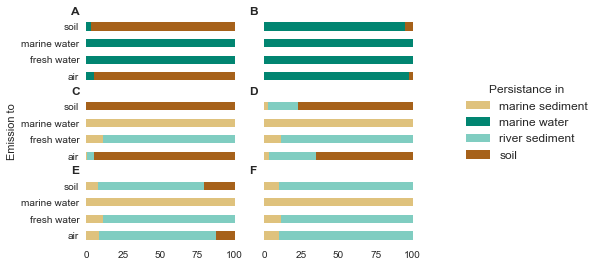

In [25]:
comp = ['air', 'fresh water', 'marine water', 'soil']

plt.style.use('seaborn')
fig = plt.figure(figsize=(11.7/2, 8.3/2))
plt.xlabel('test')
G = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
plt.rc('font', size=12)
color = ['#dfc27d', '#018571', '#80cdc1', '#a6611a']
axes_5 = plt.subplot(G[2, 0])
axes_6 = plt.subplot(G[2, 1])
axes_1 = plt.subplot(G[0, 0], sharex=axes_5)
axes_2 = plt.subplot(G[0, 1], sharex=axes_6)
axes_3 = plt.subplot(G[1, 0], sharex=axes_5)
axes_4 = plt.subplot(G[1, 1], sharex=axes_6)

#axes_1 = Group_1
axes_1.text(-0.1, 1.05, 'A', transform=axes_1.transAxes,
            size=12, weight='bold')
df_FF_reduced_limited[df_FF_reduced_limited.Polymer_type == 'HDPE'].plot(kind='barh', rot=0, ax=axes_1, stacked=True,
                                                                         legend=False, color=color)
axes_1.set(facecolor = "white")
axes_1.set_yticklabels(comp)
axes_1.set_ylabel((None))
axes_1.set_xlim(0, 100)
#axes_2 = Group_2
axes_2.text(-.1, 1.05, 'B', transform=axes_2.transAxes, size=12, weight='bold')
df_FF_reduced_limited[df_FF_reduced_limited.Polymer_type == 'PE'].plot(kind='barh', rot=0, ax=axes_2, stacked=True,
                                                                       legend=False, color=color)
axes_2.set(facecolor = "white")
axes_2.set_ylabel((None))
axes_2.set_xlim(0, 100)
plt.setp(axes_2.get_yticklabels(), visible=False)
#axes_3 = Group_3
axes_3.text(-0.1, 1.05, 'C', transform=axes_3.transAxes,
            size=12, weight='bold')
df_FF_reduced_limited[df_FF_reduced_limited.Polymer_type == 'NR/SBR'].plot(kind='barh', rot=0, ax=axes_3, stacked=True,
                                                                           legend=False, color=color)
axes_3.set(facecolor = "white")
axes_3.set_yticklabels(comp)
axes_3.set_ylabel((None))
axes_3.set_ylabel(('Emission to'))
axes_3.set_xlim(0, 100)
#axes_4 = Group_4
axes_4.text(-.1, 1.05, 'D', transform=axes_4.transAxes, size=12, weight='bold')
df_FF_reduced_limited[df_FF_reduced_limited.Polymer_type == 'PBS'].plot(kind='barh', rot=0, ax=axes_4, stacked=True,
                                                                        legend=False, color=color)
axes_4.set(facecolor = "white")
axes_4.set_ylabel((None))
axes_4.set_xlim(0, 100)
plt.setp(axes_4.get_yticklabels(), visible=False)
#axes_5 = Group_5
axes_5.text(-0.1, 1.05, 'E', transform=axes_5.transAxes,
            size=12, weight='bold')
df_FF_reduced_limited[df_FF_reduced_limited.Polymer_type == 'PHA'].plot(kind='barh', rot=0, ax=axes_5, stacked=True,
                                                                        legend=False, color=color)
axes_5.set(facecolor = "white")
axes_5.set_yticklabels(comp)
axes_5.set_ylabel((None))
axes_5.set_xlim(0, 100)
#axes_6 = Group_6
axes_6.text(-.1, 1.05, 'F', transform=axes_6.transAxes, size=12, weight='bold')
df_FF_reduced_limited[df_FF_reduced_limited.Polymer_type == 'PLA(-blend)'].plot(kind='barh', rot=0, ax=axes_6,
                                                                                stacked=True, legend=False, color=color)
axes_6.set(facecolor = "white")
axes_6.set_ylabel((None))
plt.xlabel(
    "Share of compartment-specific fate factors to the total fate factor [%]", x=0)
axes_6.set_xlim(0, 100)
plt.setp(axes_6.get_yticklabels(), visible=False)
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, ('marine sediment', 'marine water', 'river sediment', 'soil'),
           loc='center left', title='Persistance in', bbox_to_anchor=(1, 0.48, 0.1, 0.1), frameon=False, fontsize='medium')
fig.savefig('FF_contribution_small.svg', bbox_inches='tight')

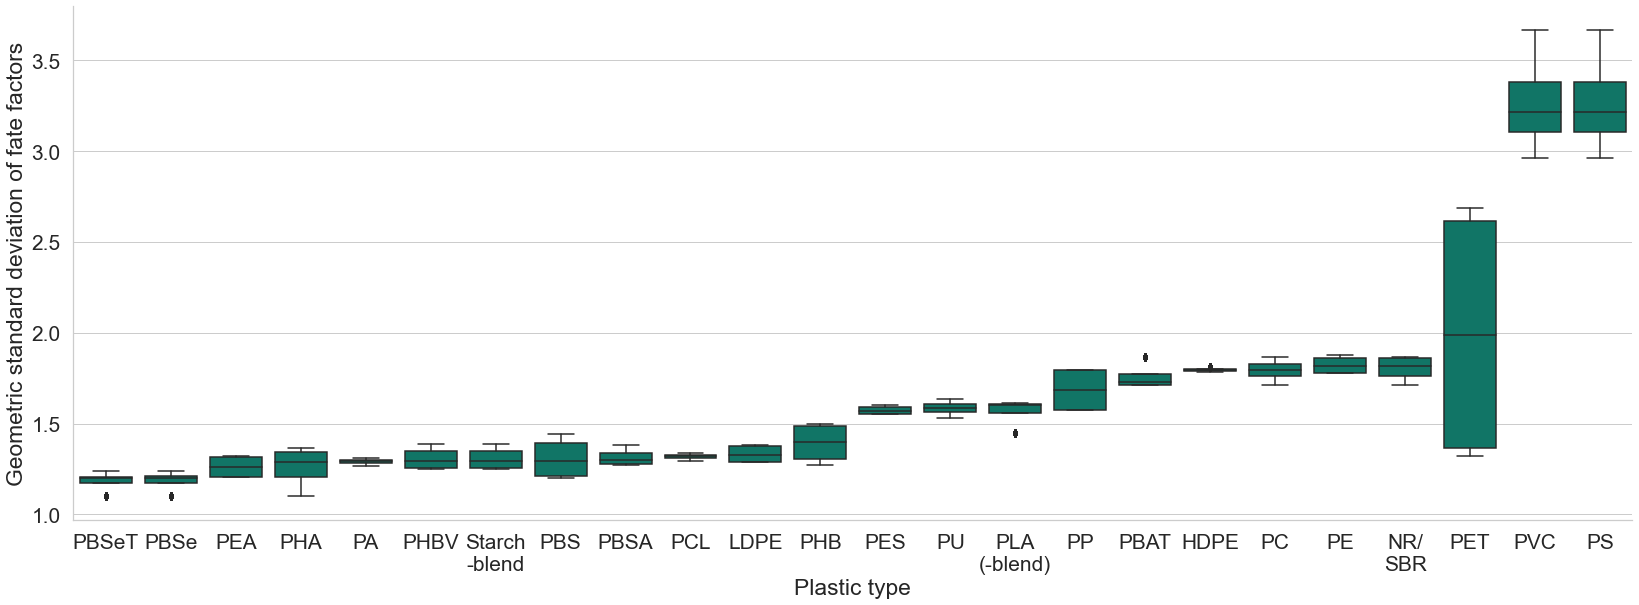

In [26]:
FF_dict = dict()

for i in range(0, len(df_FF)):
    name = df_FF.iloc[i]['Environmental_flow'].split()[0]
    GSDi = df_FF.loc[(
        df_FF['Environmental_flow'].str.startswith(name + ' ')), ['GSD']]
    GSDi = GSDi['GSD'].values.tolist()
    FF_dict[name] = GSDi
FF_GSD_boxplot = pd.DataFrame.from_dict(FF_dict)
sorted_index = FF_GSD_boxplot.median().sort_values().index
FF_GSD_boxplot_sorted = FF_GSD_boxplot[sorted_index]

FF_GSD_boxplot_sorted = FF_GSD_boxplot_sorted.rename(columns={'Starch-blend': 'Starch\n-blend',
                                                              'PLA(-blend)': 'PLA\n(-blend)',
                                                              'NR/SBR': 'NR/\nSBR'})

df_new = df.rename(columns={'A': 'Col_1'}, index={'ONE': 'Row_1'})
sns.set(font_scale=1.9)
sns.set_style("whitegrid")

g = sns.catplot(data=FF_GSD_boxplot_sorted, orient="v",
                kind="box", color='#018571')
g.set(xlabel='Plastic type', ylabel='Geometric standard deviation of fate factors')
# g.set_xticklabels(rotation=30)
g.fig.set_figwidth(30)
g.fig.set_figheight(10)

g.savefig('FF_GSD_boxplot_sorted.svg')

In [29]:
FF_GSD_boxplot_sorted.loc['Median'] = FF_GSD_boxplot_sorted[0:144].median()
def find_iqr(x):
  return np.subtract(*np.percentile(x, [75, 25]))
FF_GSD_boxplot_sorted.loc['IQR'] = FF_GSD_boxplot_sorted[0:144].apply(find_iqr)
FF_GSD_boxplot_sorted

,PBSeT,PBSe,PEA,PHA,PA,PHBV,Starch\n-blend,PBS,PBSA,PCL,...,PLA\n(-blend),PP,PBAT,HDPE,PC,PE,NR/\nSBR,PET,PVC,PS
0,1.198034,1.199458,1.314871,1.366625,1.287344,1.250641,1.250641,1.216773,1.273265,1.314632,...,1.598978,1.573799,1.712965,1.783331,1.781498,1.876427,1.780156,2.593003,3.151354,3.151354
1,1.198034,1.199458,1.314871,1.366625,1.287344,1.250641,1.250641,1.216773,1.273265,1.314632,...,1.598978,1.573799,1.712965,1.783331,1.781498,1.876427,1.780156,2.593003,3.151354,3.151354
2,1.198034,1.199458,1.314871,1.366625,1.287344,1.250641,1.250641,1.216773,1.273265,1.314632,...,1.598978,1.573799,1.712965,1.783331,1.781498,1.876427,1.780156,2.593003,3.151354,3.151354
3,1.198034,1.199458,1.314871,1.366625,1.287344,1.250641,1.250641,1.216773,1.273265,1.314632,...,1.598978,1.573799,1.712965,1.783331,1.781498,1.876427,1.780156,2.593003,3.151354,3.151354
4,1.237266,1.237266,1.203538,1.237266,1.265816,1.332288,1.332288,1.374323,1.325239,1.290780,...,1.445240,1.792868,1.711223,1.792868,1.712426,1.778615,1.711223,1.322321,2.963819,2.963819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1.196659,1.196526,1.323735,1.338495,1.295295,1.257224,1.257224,1.197508,1.277433,1.323494,...,1.603478,1.574622,1.738881,1.812068,1.811089,1.852258,1.857257,2.689507,3.284080,3.284080
142,1.196659,1.196526,1.323735,1.338495,1.295295,1.257224,1.257224,1.197508,1.277433,1.323494,...,1.603478,1.574622,1.738881,1.812068,1.811089,1.852258,1.857257,2.689507,3.284080,3.284080
143,1.196659,1.196526,1.323735,1.338495,1.295295,1.257224,1.257224,1.197508,1.277433,1.323494,...,1.603478,1.574622,1.738881,1.812068,1.811089,1.852258,1.857257,2.689507,3.284080,3.284080
Median,1.197347,1.197992,1.259204,1.287881,1.291320,1.294756,1.294756,1.295548,1.301336,1.319063,...,1.601228,1.683745,1.725923,1.792868,1.796294,1.815437,1.818707,1.985126,3.217717,3.217717


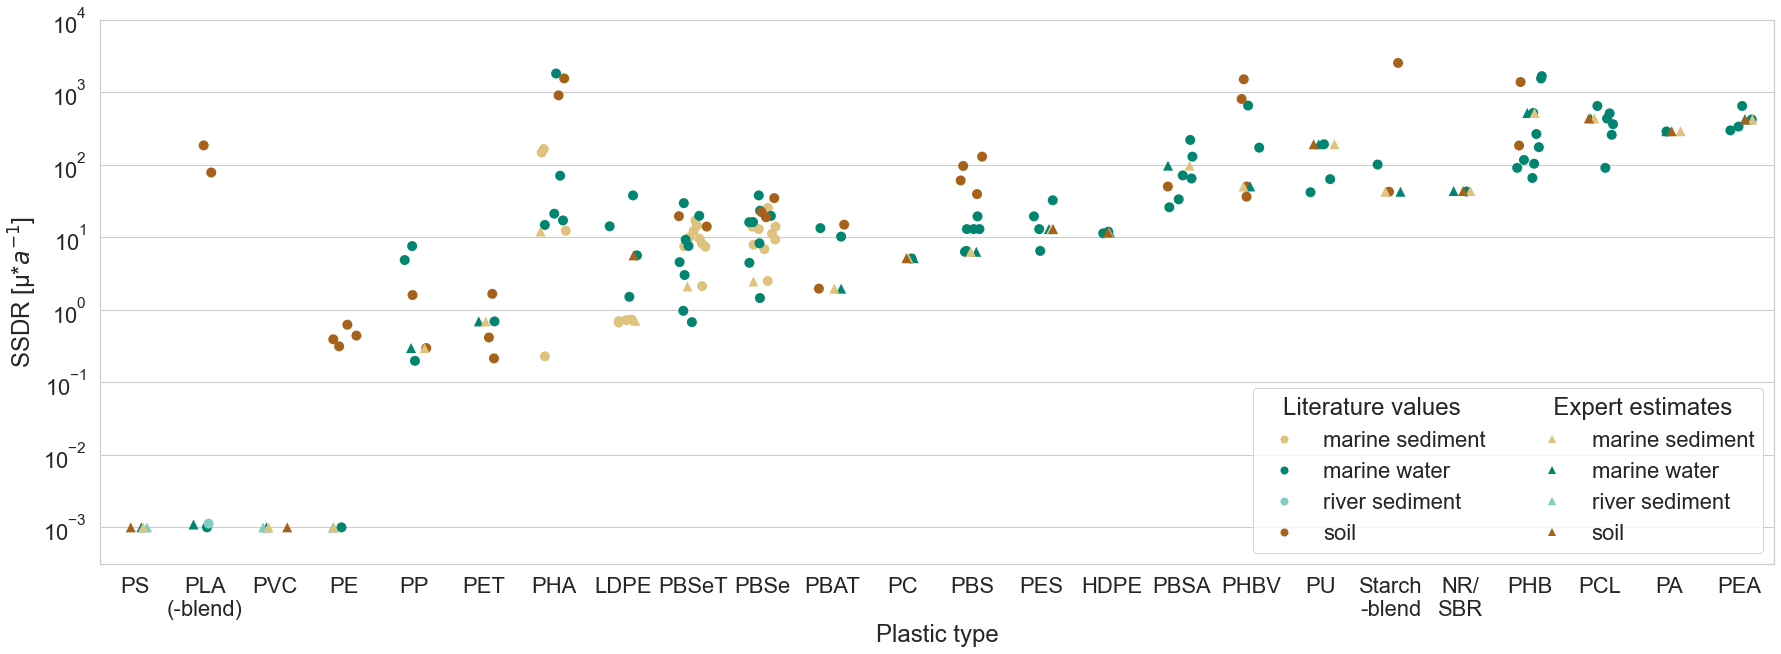

In [34]:
df['Polymer type'] = df['Polymer type'].replace(
    ['Starch-blend', 'PLA(-blend)', 'NR/SBR'], ['Starch\n-blend', 'PLA\n(-blend)', 'NR/\nSBR'])
non_expert = df[df['SSDR expert judgment based on'].isna() & (
    df['Source'] != "Experts' estimate")]
expert = df[(df['SSDR expert judgment based on'].notnull())
            | (df['Source'] == "Experts' estimate")]
color = ['#018571', '#dfc27d', '#a6611a', '#80cdc1']
legend_elements = [Line2D([0], [0], linewidth=0, marker='o', color='#dfc27d', label='marine sediment', markersize=8),
                   Line2D([0], [0], linewidth=0, marker='o',
                          color='#018571', label='marine water', markersize=8),
                   Line2D([0], [0], linewidth=0, marker='o',
                          color='#80cdc1', label='river sediment', markersize=8),
                   Line2D([0], [0], linewidth=0, marker='o',
                          color='#a6611a', label='soil', markersize=8),
                   Line2D([0], [0], linewidth=0, marker='^', color='#dfc27d',
                          label='marine sediment', markersize=8),
                   Line2D([0], [0], linewidth=0, marker='^',
                          color='#018571', label='marine water', markersize=8),
                   Line2D([0], [0], linewidth=0, marker='^',
                          color='#80cdc1', label='river sediment', markersize=8),
                   Line2D([0], [0], linewidth=0, marker='^', color='#a6611a', label='soil', markersize=8)]
df_sorted = df.sort_values(by='SSDR')
poly_sorted_by_SSDR = df_sorted['Polymer type'].unique().tolist()
poly_sorted_by_SSDR

sns.set(font_scale=2, rc={'figure.figsize': (30, 10)})
sns.set_style("whitegrid")
g = sns.stripplot(x="Polymer type", y="SSDR", hue='Compartment', palette=sns.color_palette(color),
                  data=non_expert, size=10, jitter=0.2, order=poly_sorted_by_SSDR)
n = sns.stripplot(x="Polymer type", y="SSDR", hue='Compartment', palette=sns.color_palette(color),
                  data=expert, marker='^', size=10, jitter=0.2, order=poly_sorted_by_SSDR)
n.set(xlabel='Plastic type',
      ylabel='SSDR [µ*$a^{-1}$]', ylim=(10**(-3.5), 10**4))
plot = g.get_figure()
n.set_yscale('log')
n.legend(title='Literature values              Expert estimates',
         handles=legend_elements, ncol=2, frameon=True)
poly_sorted_by_SSDR[1] = 'PLA\n(-blend)'
plot = n.get_figure()

plot.savefig('SSDR.svg', bbox_inches='tight')